# THE APPLICATION OF DEEP LEARNING METHODOLOGIES IN THE CLASSIFICATION OF SKIN CANCER
Dataset Link:https://www.kaggle.com/datasets/bhaveshmittal/melanoma-cancer-dataset

**About Dataset**:  The dataset comprised 13,900 meticulously curated image of two classes namely Benign and Maiignant. The images, uniformly sized at 224 x 224 pixels, offer a comprehensive view of melanoma's diverse manifestations.

**Study Aim**: The central objective of this study is to examine the applicaion of deep learning in health field particularly dermatology, particularly exploring its potential in skin cancer diagnosis. I aim to develop and evaluate two deep learning models, then compare their efficacy in classifying different stages of skin cancer using dermoscopy images.










## Mount and Upload the Unzipped images dataset into Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os


#Path to the zip file
zip_file_path = '/content/drive/My Drive/Cancer.zip'

#Destination folder to extract files
extract_folder = '/content/drive/My Drive/Cancer_data'

#Create the destination folder if it doesn't exist
if not os.path.exists(extract_folder):
    os.makedirs(extract_folder)

#Extract files from the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)



In [3]:
import os
extract_folder = '/content/drive/My Drive/Cancer_data'
extracted_files = os.listdir(extract_folder)

#Confirm the availability of each extracted file
print("Files extracted successfully:")
for file_name in extracted_files:
    file_path = os.path.join(extract_folder, file_name)
    if os.path.exists(file_path):
        print(f"{file_name}: Available")
    else:
        print(f"{file_name}: Not Available")

Files extracted successfully:
test: Available
train: Available


## IMAGES EXTRACTION

In [4]:
import cv2
import numpy as np
images = []
labels = []
IMG_SIZE = 200
max_images = 1500
def extract_train_data(data_type, parent_dir, class_name):

    #create full path of the data directory
    dir_path = os.path.join(parent_dir, data_type)
    #count the images
    images_count = 0
    label = class_name
    path = os.path.join(dir_path, class_name)
    for image in os.listdir(path):
      if images_count >= max_images:
            #stop at 1500 images
            return
      image_path = os.path.join(path, image)
      img = cv2.imread(image_path, cv2.IMREAD_COLOR)
      img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

      images.append(np.array(img))
      labels.append(str(label))
      images_count += 1


In [5]:
#extract the images and the labels
for classes in os.listdir(os.path.join(extract_folder, "train")):
  extract_train_data("train", extract_folder, classes)

In [6]:
#to check the length of the extracted images
len(images)

3000

## EXPLORATORY DATA ANALYSIS

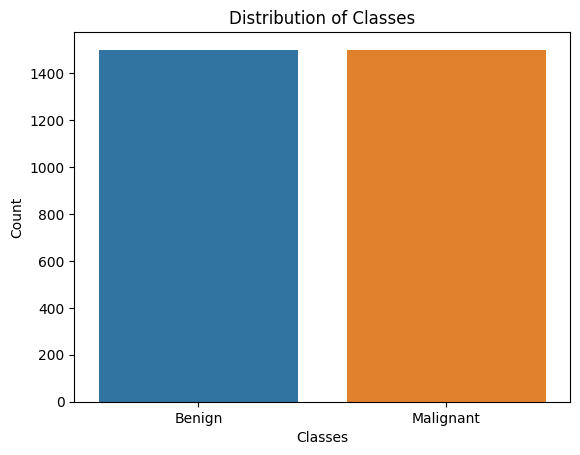

In [7]:
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

# Count the occurrences of each class
counter = Counter(labels)
classes = list(counter.keys())
counts = list(counter.values())

#create the distribution barplot
sns.barplot(x = classes, y = counts, hue = classes, legend = False)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Distribution of Classes')
plt.show()


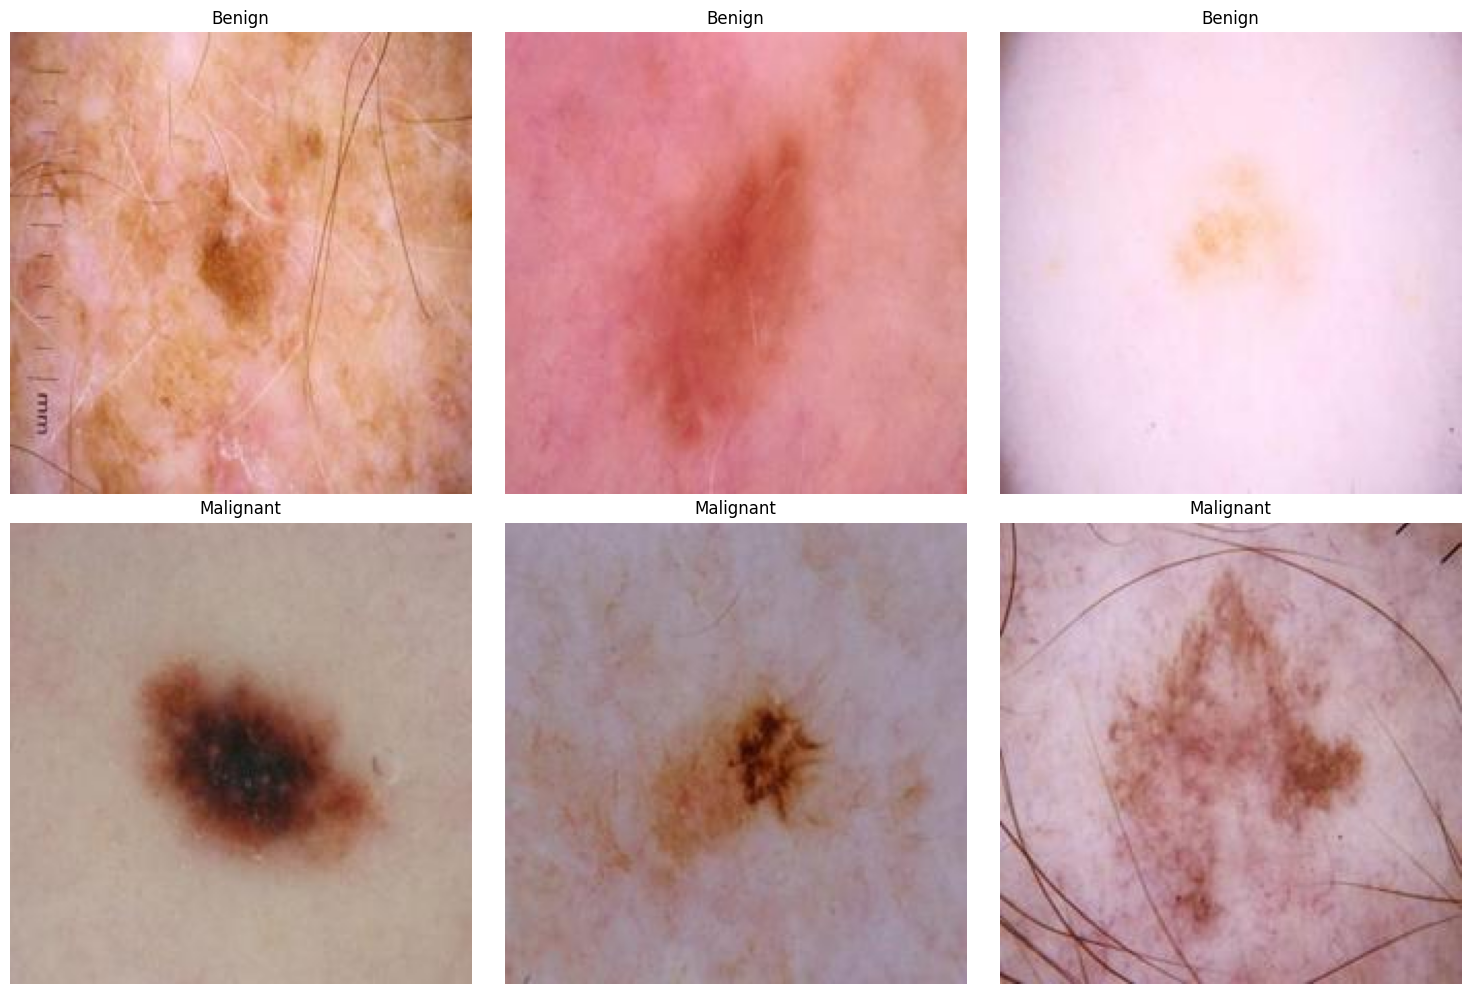

In [8]:
import random
from PIL import Image
def show_sample_images(data_dir, classes, num_images):
    fig, ax = plt.subplots(len(classes), num_images, figsize=(5*num_images, 5*len(classes)))

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        class_files = os.listdir(class_dir)

        #select random images
        sample_files = random.sample(class_files, num_images)

        for j, file_name in enumerate(sample_files):
            img_path = os.path.join(class_dir, file_name)
            img = Image.open(img_path)
            ax[i, j].imshow(img)
            ax[i, j].set_title(class_name)
            #set off the axis
            ax[i, j].axis('off')

    plt.tight_layout()
    plt.show()

#set the directory
data_dir = os.path.join(extract_folder,"train")
#show the images
show_sample_images(data_dir, classes, 3)

## DATA PREPROCESSING AND PREPARATION

In [9]:
#import the packages to encode the labels
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [10]:
#encode the label
Encoder = LabelEncoder()
encode_label = Encoder.fit_transform(labels)
one_hot_y = to_categorical(encode_label, 2)

In [11]:
one_hot_y[0]

array([1., 0.], dtype=float32)

In [12]:
#convert the images into numpy array and scale them
normalize_images = np.array(images)
X = normalize_images/255

In [13]:
np.random.seed(30)
from sklearn.model_selection import train_test_split
#spit the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, one_hot_y, test_size=0.3)

## TRAINING THE CONVENTIONAL CNN MODEL

In [14]:
#import required packages for creating a convolutional model
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, Dense, Flatten, Activation

In [ ]:
import warnings
#ignore warnings
warnings.filterwarnings("ignore")
#set the number of classes
num_classes = 2
#initiaize the model
model = Sequential()
#add layers to the model
model.add(Conv2D(32, kernel_size = (5,5),padding = 'same',activation ='relu',
                 input_shape = (IMG_SIZE,IMG_SIZE,3),  kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, kernel_size = (3,3),padding = 'same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(128, kernel_size = (3,3),padding = 'same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(128, kernel_size = (3,3),padding = 'same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
#add another activation layer
model.add(Activation('relu'))

In [ ]:
#compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 100, 100, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 50, 50, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 25, 25, 128)       0

In [ ]:
np.random.seed(30)
#tran the model at 20 epochs
cancer_model = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 20, verbose = 1)

Epoch 1/20
66/66 [==============================] - 19s 119ms/step - loss: 0.6885 - accuracy: 0.6138 - val_loss: 1.2011 - val_accuracy: 0.4989
Epoch 2/20
66/66 [==============================] - 4s 58ms/step - loss: 0.6476 - accuracy: 0.6381 - val_loss: 0.6308 - val_accuracy: 0.7467
Epoch 3/20
66/66 [==============================] - 3s 53ms/step - loss: 0.5206 - accuracy: 0.7638 - val_loss: 0.4719 - val_accuracy: 0.7856
Epoch 4/20
66/66 [==============================] - 3s 53ms/step - loss: 0.4713 - accuracy: 0.7914 - val_loss: 0.4884 - val_accuracy: 0.7922
Epoch 5/20
66/66 [==============================] - 3s 51ms/step - loss: 0.4589 - accuracy: 0.8105 - val_loss: 0.4223 - val_accuracy: 0.8111
Epoch 6/20
66/66 [==============================] - 4s 54ms/step - loss: 0.4295 - accuracy: 0.8229 - val_loss: 0.4122 - val_accuracy: 0.8356
Epoch 7/20
66/66 [==============================] - 3s 50ms/step - loss: 0.4320 - accuracy: 0.8176 - val_loss: 0.5097 - val_accuracy: 0.7622
Epoch 8/20


## EVALUATING THE CONVENTIONAL CNN MODEL

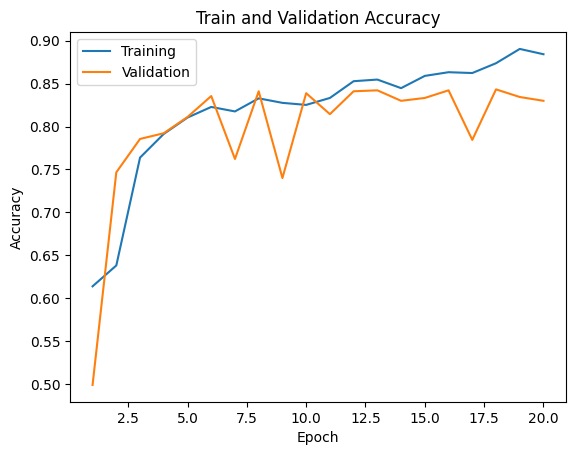

In [ ]:
plt.title("Train and Validation Accuracy")
#plot the conventional training and validation accuracy against epoch
plt.plot(range(1,21), cancer_model.history['accuracy'], label = "Training")
plt.plot(range(1,21), cancer_model.history['val_accuracy'], label = "Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

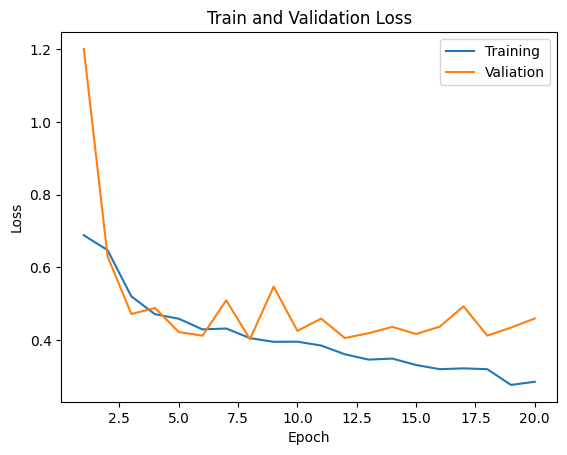

In [ ]:
plt.title("Train and Validation Loss")
#plot the train and validation loss history
plt.plot(range(1,21), cancer_model.history['loss'], label = "Training")
plt.plot(range(1,21), cancer_model.history['val_loss'], label = "Valiation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#predict classes of images in the test data
predicted_classes = model.predict(X_test)
predictions = np.argmax(predicted_classes, axis=1)
true = np.argmax(y_test, axis = 1)

29/29 [==============================] - 1s 17ms/step


In [ ]:
from sklearn.metrics import accuracy_score
#evaluate the accuracy score
accuracy =  accuracy_score(predictions, true) *100
print("The model has an accuracy of {:.2f}%".format(accuracy))

The model has an accuracy of 83.00%


In [ ]:
from sklearn.metrics import classification_report
#print the classification report
print(classification_report(predictions, true))

              precision    recall  f1-score   support

           0       0.78      0.87      0.82       404
           1       0.88      0.80      0.84       496

    accuracy                           0.83       900
   macro avg       0.83      0.83      0.83       900
weighted avg       0.84      0.83      0.83       900



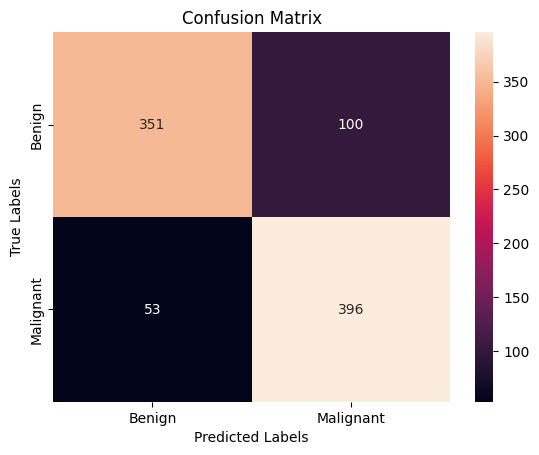

In [ ]:
classes = ["Benign", "Malignant"]

from sklearn.metrics import confusion_matrix

#evaluate the classification confusion matrix
cm = confusion_matrix(true, predictions)

sns.heatmap(cm, annot=True, fmt='d', xticklabels = classes, yticklabels = classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


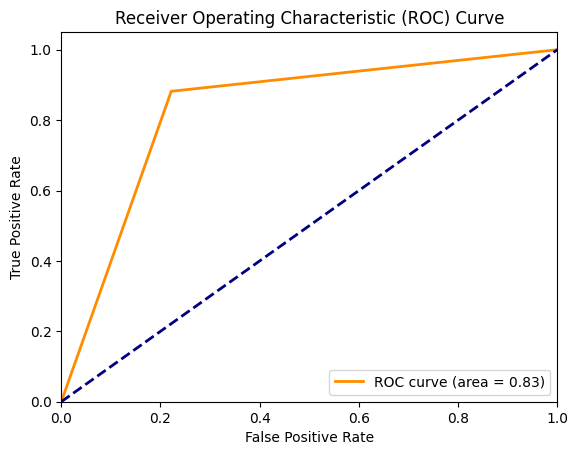

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(true, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


## TRAINING TRANSFER LEARNING MODEL

In [15]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD

# Load pre-trained VGG16 model without the top layer (include_top=False)
base_model = VGG16(weights='imagenet', include_top=False)

# Add custom top layers for your classification task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)  # NUM_CLASSES is the number of classes in your dataset

# Define the model
transfer_model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the pre-trained model (optional)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
transfer_model.compile(optimizer=SGD(learning_rate = 0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])



58889256/58889256 [==============================] - 0s 0us/step


In [16]:
transfer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [17]:
# Train the transfer learning model
np.random.seed(30)
transfer_model_history = transfer_model.fit(
    X_train, y_train,
    epochs = 10,
    validation_data=(X_test, y_test))

Epoch 1/10
66/66 [==============================] - 27s 282ms/step - loss: 0.7043 - accuracy: 0.5752 - val_loss: 0.6458 - val_accuracy: 0.6278
Epoch 2/10
66/66 [==============================] - 10s 156ms/step - loss: 0.6240 - accuracy: 0.7252 - val_loss: 0.6000 - val_accuracy: 0.7489
Epoch 3/10
66/66 [==============================] - 10s 160ms/step - loss: 0.5884 - accuracy: 0.7452 - val_loss: 0.5805 - val_accuracy: 0.7056
Epoch 4/10
66/66 [==============================] - 13s 193ms/step - loss: 0.5597 - accuracy: 0.7671 - val_loss: 0.5423 - val_accuracy: 0.7833
Epoch 5/10
66/66 [==============================] - 13s 197ms/step - loss: 0.5352 - accuracy: 0.7848 - val_loss: 0.5211 - val_accuracy: 0.7833
Epoch 6/10
66/66 [==============================] - 13s 200ms/step - loss: 0.5218 - accuracy: 0.7681 - val_loss: 0.5196 - val_accuracy: 0.7678
Epoch 7/10
66/66 [==============================] - 12s 177ms/step - loss: 0.5084 - accuracy: 0.7729 - val_loss: 0.4913 - val_accuracy: 0.7867

## EVALUATING THE TRANSFER LEARNING MODEL

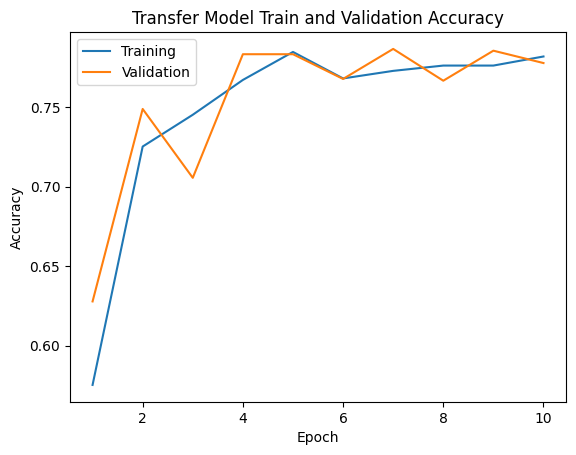

In [19]:
plt.title("Transfer Model Train and Validation Accuracy")
#plot the training and validation accuracy against epoch
plt.plot(range(1,11), transfer_model_history.history['accuracy'], label = "Training")
plt.plot(range(1,11), transfer_model_history.history['val_accuracy'], label = "Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

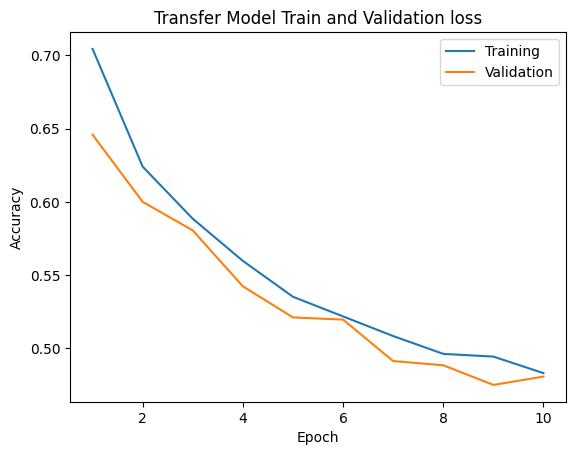

In [20]:
plt.title("Transfer Model Train and Validation loss")
#plot the training and validation loss against epoch
plt.plot(range(1,11), transfer_model_history.history['loss'], label = "Training")
plt.plot(range(1,11), transfer_model_history.history['val_loss'], label = "Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
#display the legend
plt.legend()
plt.show()

In [21]:
#make predictions with the transfer learning model
transfer_model_pred = transfer_model.predict(X_test)
tf_predictions = np.argmax(transfer_model_pred, axis=1)
true = np.argmax(y_test, axis = 1)

29/29 [==============================] - 4s 122ms/step


In [22]:
from sklearn.metrics import accuracy_score
#evaluate the model accuracy
accuracy =  accuracy_score(tf_predictions, true) *100
print("The transfer learning model has an accuracy of {:.2f}%".format(accuracy))

The transfer learning model has an accuracy of 77.78%


In [23]:
from sklearn.metrics import classification_report
#print the classification report
print(classification_report(tf_predictions, true))

              precision    recall  f1-score   support

           0       0.72      0.81      0.76       399
           1       0.84      0.75      0.79       501

    accuracy                           0.78       900
   macro avg       0.78      0.78      0.78       900
weighted avg       0.78      0.78      0.78       900



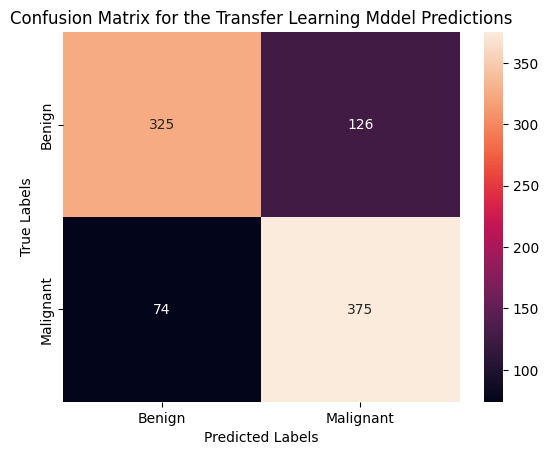

In [24]:
classes = ["Benign", "Malignant"]

from sklearn.metrics import confusion_matrix

#evaluate the confusion matrix
cm = confusion_matrix(true, tf_predictions)
#create confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt='d', xticklabels = classes, yticklabels = classes)
plt.title('Confusion Matrix for the Transfer Learning Mddel Predictions')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

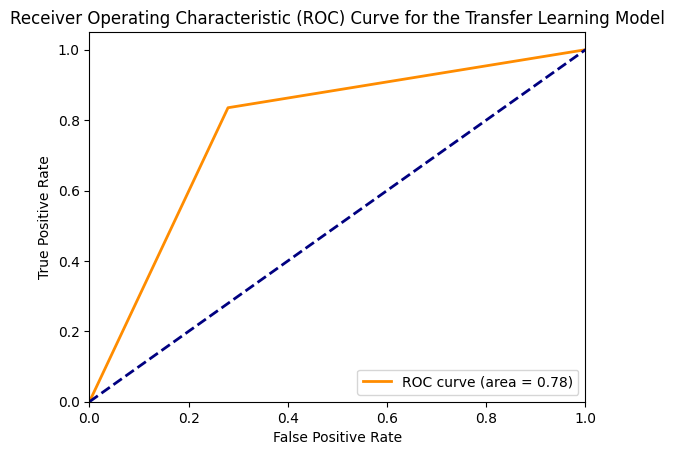

In [25]:
from sklearn.metrics import roc_curve, auc


# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(true, tf_predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#set x limit
plt.xlim([0.0, 1.0])
#set y limit
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for the Transfer Learning Model')
#display the legend at the lower right position
plt.legend(loc="lower right")
plt.show()
